In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import expm1 
from sasmodels.special import sas_3j1x_x, sas_sinx_x

In [2]:
def get_contrasts(d):
    rho_solv = 1

    if d==1:
        # Homogenous
        rho_s = rho_solv+1
        rho_c = rho_solv+1
    if d==2:
        # Shell
        rho_s = rho_solv
        rho_c = rho_solv+1
    if d==3:
        # core
        rho_s = rho_solv+1
        rho_c = rho_solv

    return rho_solv, rho_s, rho_c

# Example (units in Å)
Vc = 4000
Vs = 4000
R = 40
Vs_total = (4/3)*np.pi*(R**3)
V_total = Vc+Vs
N = Vs_total/Vs
Rg = 10
d = 1.0
rho_solv, rho_s, rho_c = get_contrasts(1)
V_total = Vs+Vc 
ndensity = 8.94

params = {'v_core' : Vc,
         'v_corona' : Vs,
         'sld_solvent' : rho_solv,
         'sld_core' : rho_s,
         'sld_corona' : rho_c,
         'radius_core': R,
         'rg': Rg,
         'd_penetration':d,
         'n_aggreg' : N,
         'ndensity' : ndensity
         }

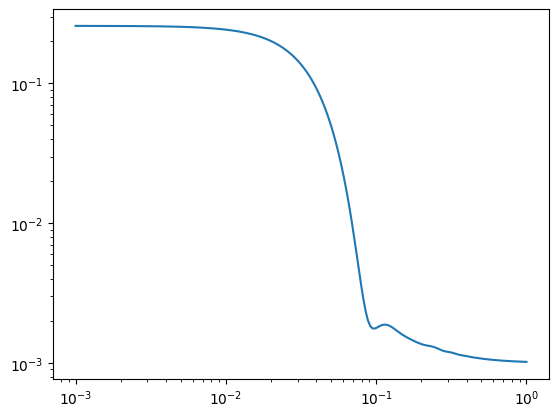

In [3]:
from sasmodels.data import empty_data1D
from sasmodels.core import load_model
from sasmodels.direct_model import DirectModel

q = np.logspace(np.log10(1e-3), np.log10(1), 200)
data = empty_data1D(q, resolution=0.05)
kernel = load_model("polymer_micelle")
f = DirectModel(data, kernel)
Iq_sasview = f(**params)
fig, ax = plt.subplots()
ax.loglog(q, Iq_sasview)
plt.show()

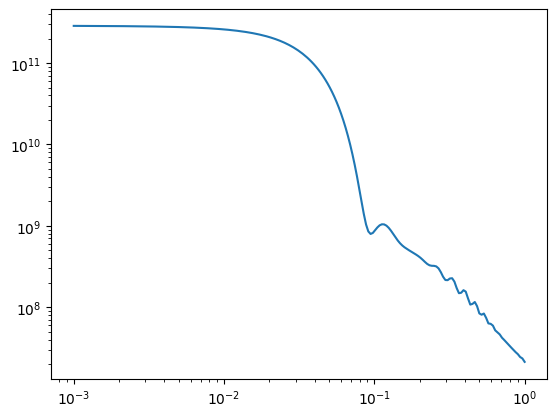

In [5]:
def micelle_spherical_kernel(q,
        ndensity=8.64,
        v_core=None,
        v_corona=None,
        sld_solvent=None,
        sld_core=None,
        sld_corona=None,
        radius_core=None,
        rg=None,
        d_penetration=None,
        n_aggreg=None):
    
    rho_solv = sld_solvent     # sld of solvent [1/A^2]
    rho_core = sld_core        # sld of core [1/A^2]
    rho_corona = sld_corona    # sld of corona [1/A^2]

    beta_core = v_core * (rho_core - rho_solv)
    beta_corona = v_corona * (rho_corona - rho_solv)

    # Self-correlation term of the core
    bes_core = sas_3j1x_x(q*radius_core)
    term1 = np.power(n_aggreg*beta_core*bes_core, 2)

    # Self-correlation term of the chains
    qrg2 = np.power(q*rg, 2)
    debye_chain = 2.0*(np.vectorize(expm1)(-qrg2)+qrg2)/(qrg2**2) 
    debye_chain[qrg2==0.0] = 1.0
    term2 = n_aggreg * beta_corona * beta_corona * debye_chain

    # Interference cross-term between core and chains
    qrg = q*rg
    chain_ampl = -np.vectorize(expm1)(-qrg)/qrg
    chain_ampl[qrg==0.0] =  1.0 
    bes_corona = sas_sinx_x(q*(radius_core + d_penetration * rg))
    term3 = 2.0 * n_aggreg * n_aggreg * beta_core * beta_corona * bes_core * chain_ampl * bes_corona

    # Interference cross-term between chains
    term4 = n_aggreg * (n_aggreg - 1.0)* np.power(beta_corona * chain_ampl * bes_corona, 2)

    # I(q)_micelle : Sum of 4 terms computed above
    i_micelle = term1 + term2 + term3 + term4

    # # rescale from [A^2] to [cm^2]
    # i_micelle *= 1e-13*1e6

    # # "normalize" by number density --> intensity in [cm-1]
    # i_micelle *= ndensity

    return i_micelle

q = np.logspace(np.log10(1e-3), np.log10(1), 200)
Iq_micelle = micelle_spherical_kernel(q, **params)
plt.loglog(q, Iq_micelle)
plt.show()

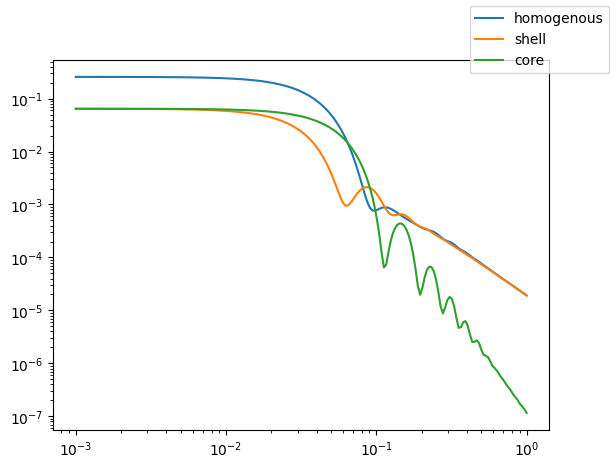

In [6]:
fig, ax = plt.subplots()
labels =['homogenous', 'shell', 'core']
for i in range(3):
    rho_solv, rho_s, rho_c = get_contrasts(i+1)
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'd_penetration':d,
            'n_aggreg' : N,
            'ndensity' : ndensity,
            'background':0.0
            }
    q = np.logspace(np.log10(1e-3), np.log10(1), 200)
    data = empty_data1D(q, resolution=0.05)
    kernel = load_model("polymer_micelle")
    f = DirectModel(data, kernel)
    Iq_sasview = f(**params)
    ax.loglog(q, Iq_sasview, label=labels[i])
fig.legend()
plt.show()

[homogenous] :  1 2 2
[shell] :  1 1 2
[core] :  1 2 1


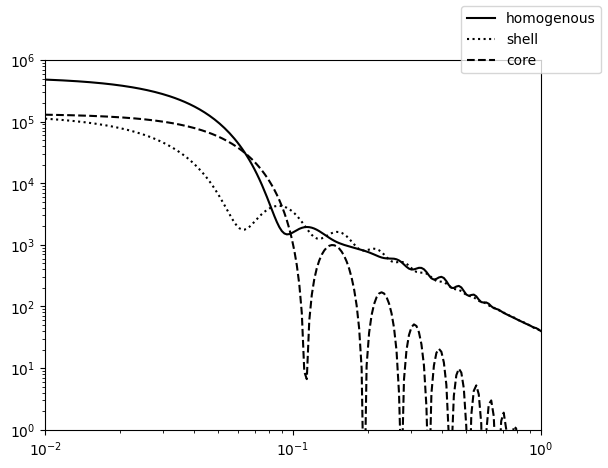

In [7]:
fig, ax = plt.subplots()
labels =['homogenous', 'shell', 'core']
linestyles = ['solid','dotted','dashed' ]
for i in range(3):
    rho_solv, rho_s, rho_c = get_contrasts(i+1)
    print('[%s] : '%labels[i], rho_solv, rho_s, rho_c)
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'd_penetration':d,
            'n_aggreg' : N,
            'ndensity' : ndensity
            }
    q = np.logspace(np.log10(1e-2), np.log10(1), 200)
    Iq_micelle = micelle_spherical_kernel(q, **params)
    # Normalize by total 'polymer' volume
    ax.loglog(q, Iq_micelle/(V_total*N), label=labels[i], ls=linestyles[i], color='k')
    ax.set_ylim([1e0, 1e6])
    ax.set_xlim([1e-2, 1e0])
fig.legend()
plt.show()